## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, resample, find_peaks
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import os
import warnings

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")

## Patient example

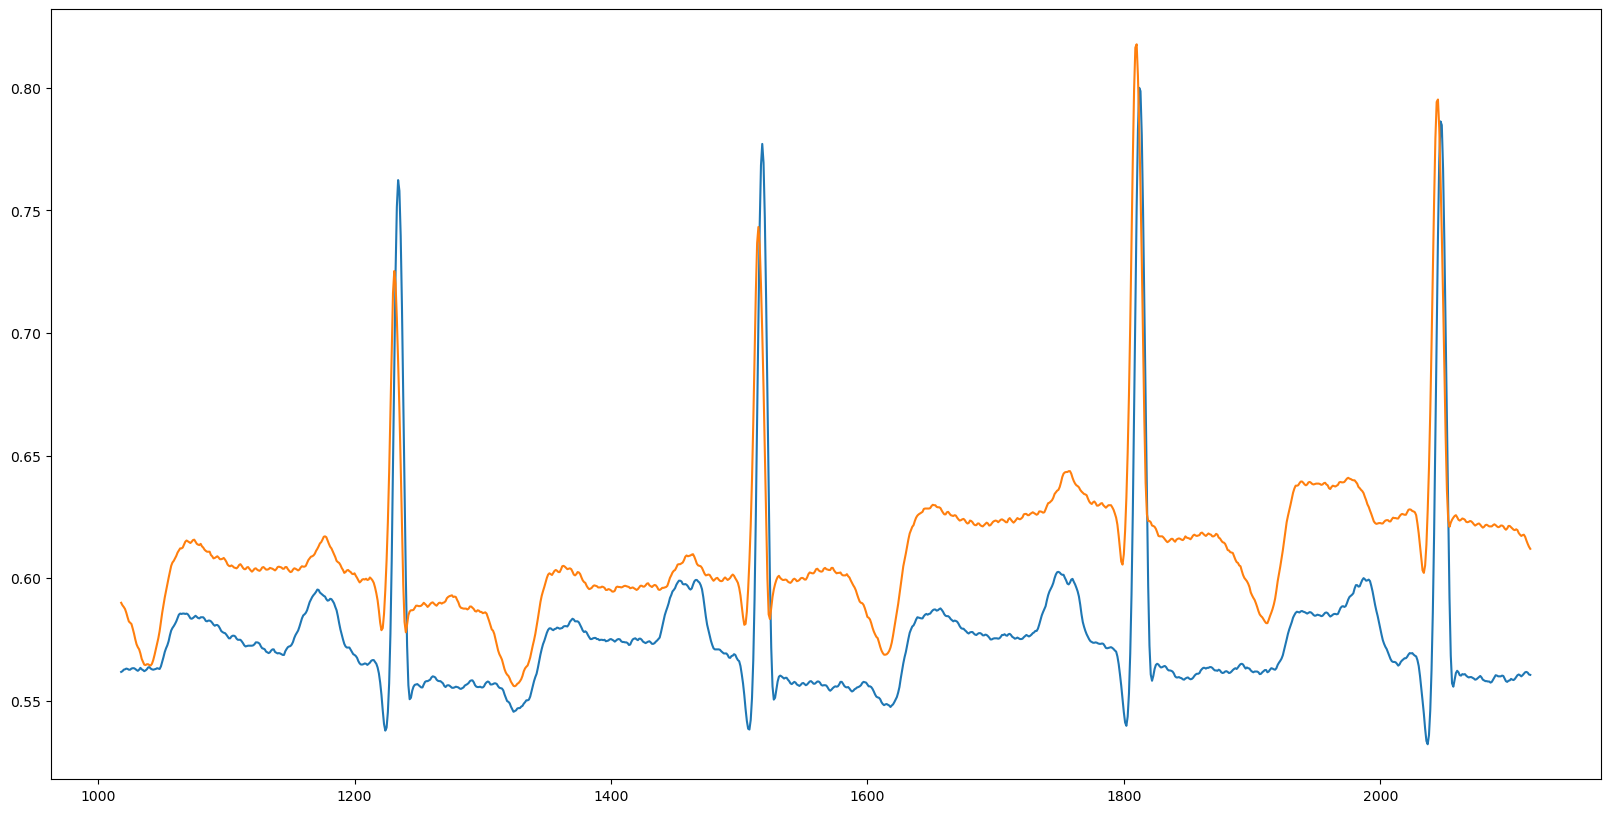

In [20]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')



# Find the first row where AUX is not NaN
index_first_non_nan = df["Aux"].first_valid_index()
if index_first_non_nan is not None:
    df = df.loc[index_first_non_nan:]

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

df.reset_index(drop=True, inplace=True)

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for index, row in beat_df.iterrows():
    sample1 = int(row['sample1'])
    sample2 = int(row['sample2'])
    # Calculate mean and std values for MLII
    mean_value = df['MLII'][sample1:sample2].mean()
    std = df['MLII'][sample1:sample2].std()
    mean_list.append(mean_value)
    std_list.append(std)

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['MLII_mean'] = mean_list
beat_df['MLII_std'] = std_list

<Figure size 2000x1000 with 0 Axes>

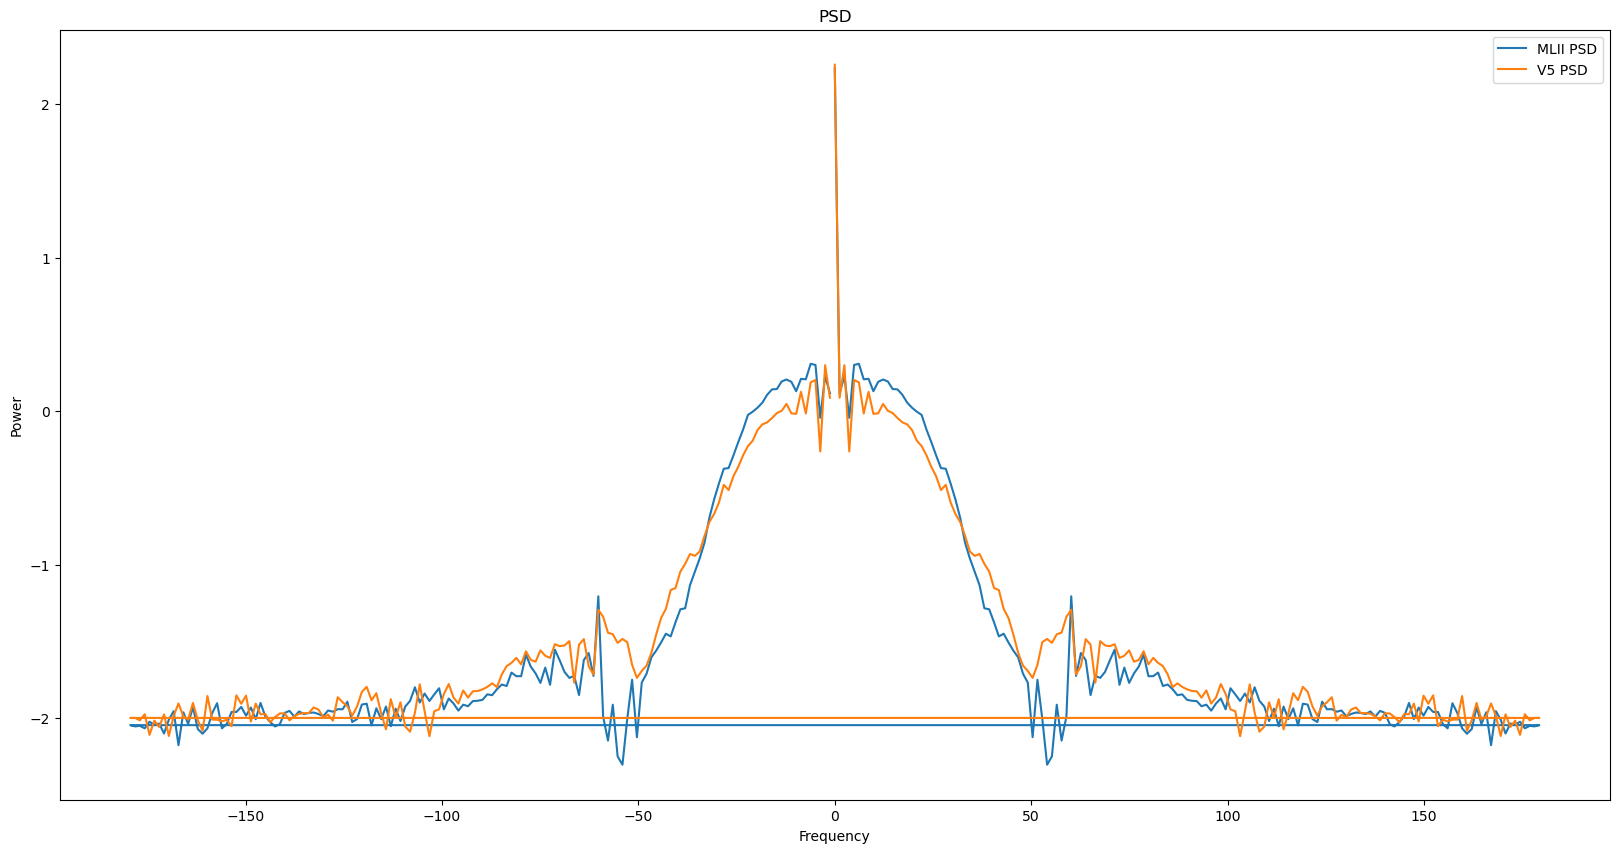

In [21]:
# Plot sample1 and sample2 for samples 59 to 352
plt.figure(figsize=(20, 10))
#plt.plot(df['Sample #'][59:352], df['MLII'][59:352])
#plt.plot(df['Sample #'][59:352], df['V5'][59:352])

# Plot psd for samples 59 to 352
psd_MLII = np.log10(np.abs(np.fft.fft(df['MLII'][59:352])))
freq_MLII = np.fft.fftfreq(len(psd_MLII), 1/360)
psd_V5 = np.log10(np.abs(np.fft.fft(df['V5'][59:352])))
freq_V5 = np.fft.fftfreq(len(psd_V5), 1/360)

plt.figure(figsize=(20, 10))
plt.plot(freq_MLII, psd_MLII)
plt.plot(freq_V5, psd_V5)
plt.title('PSD')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(['MLII PSD', 'V5 PSD'])


In [22]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df_raw = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

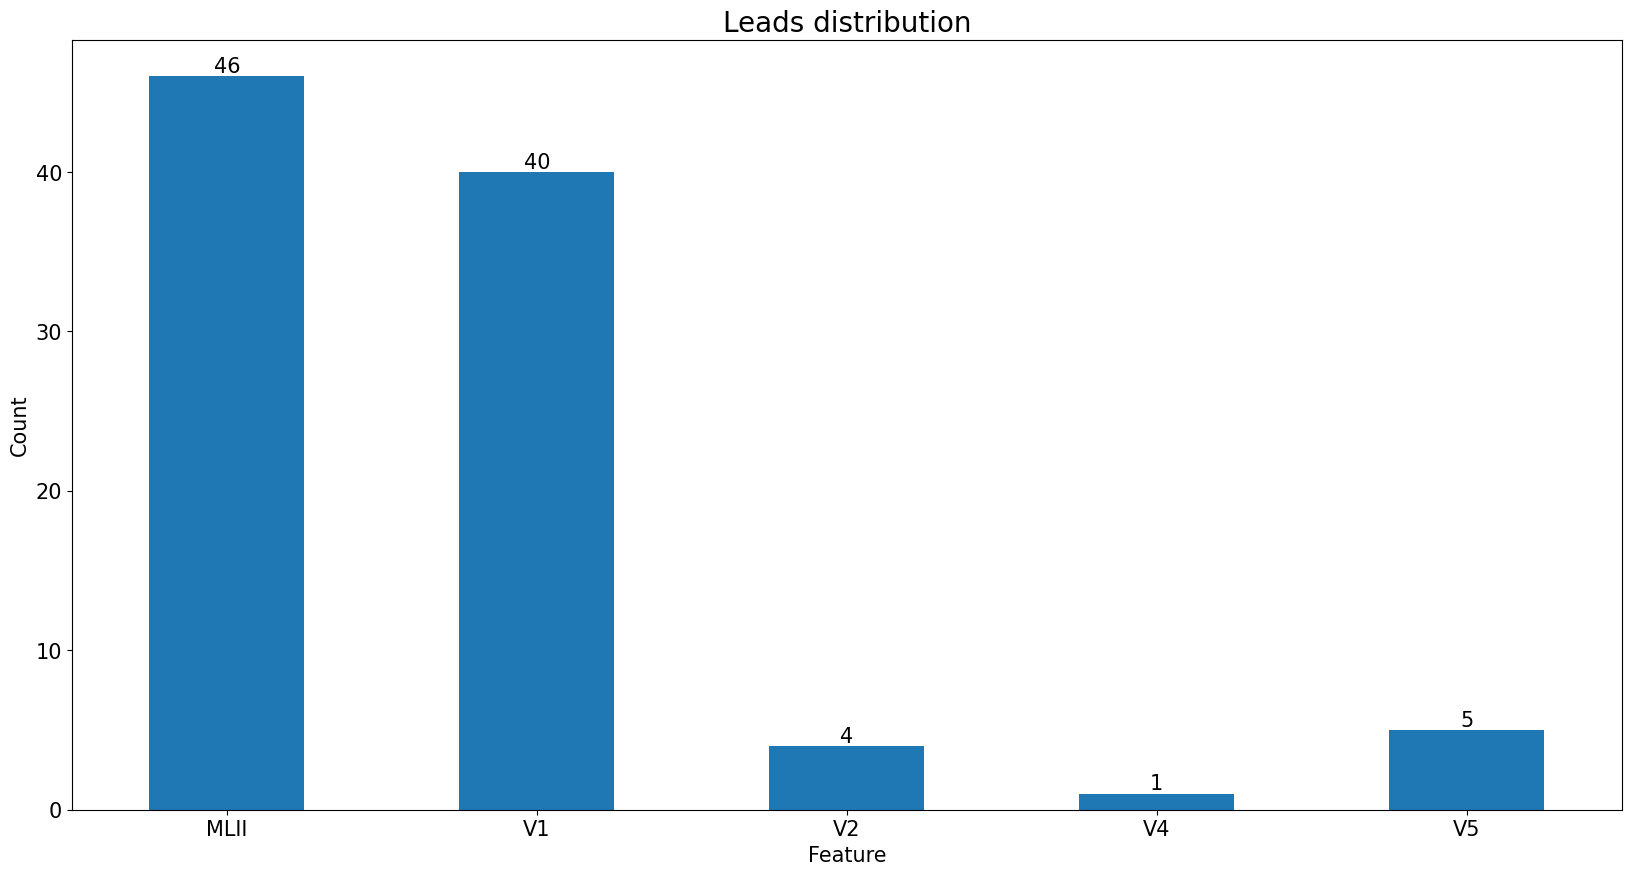

In [23]:
# Plot the number of samples for features MLII, V1, V2, V4, V5 in a bar plot and include the count on top of the bars
plt.figure(figsize=(20, 10))
(df_raw[['MLII', 'V1', 'V2', 'V4', 'V5']].count()/650000).plot(kind='bar')
for index, value in enumerate(df_raw[['MLII', 'V1', 'V2', 'V4', 'V5']].count()/650000):
    plt.text(index, value, str(int(value)), ha='center', va='bottom', fontsize=15)
plt.title('Leads distribution', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## All Patients Data Import

In [24]:
# Get all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Read all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        df_temp.columns = df_temp.columns[:-2].tolist() + ['Signal 1', 'Signal 2']
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Read all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merge ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

# Create df_copy with only non-NaN values in Time column
df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

### Dataset truncation

In [25]:
# Create dataframe to truncate the data
filtered_data = pd.DataFrame()

# Iterate through each unique patient
for patient_id, group in df.groupby('Patient'):
    # Find the first row where AUX is not NaN
    index_first_non_nan = group['Aux'].first_valid_index()
    if index_first_non_nan is not None:
        filtered_data = pd.concat([filtered_data, group.loc[index_first_non_nan:]], ignore_index=True)

df = filtered_data

# Based on the time of the annotations, fill the NaN values with the previous annotation for the Type column
df['Type'] = df['Type'].fillna(method='ffill')

### Dataset information

Sample #    31197531
Signal 1    31197531
Signal 2    31197531
Patient     31197531
Time          112646
Type        31197531
Sub           112646
Chan          112646
Num           112646
Aux             1728
dtype: int64


<BarContainer object of 10 artists>

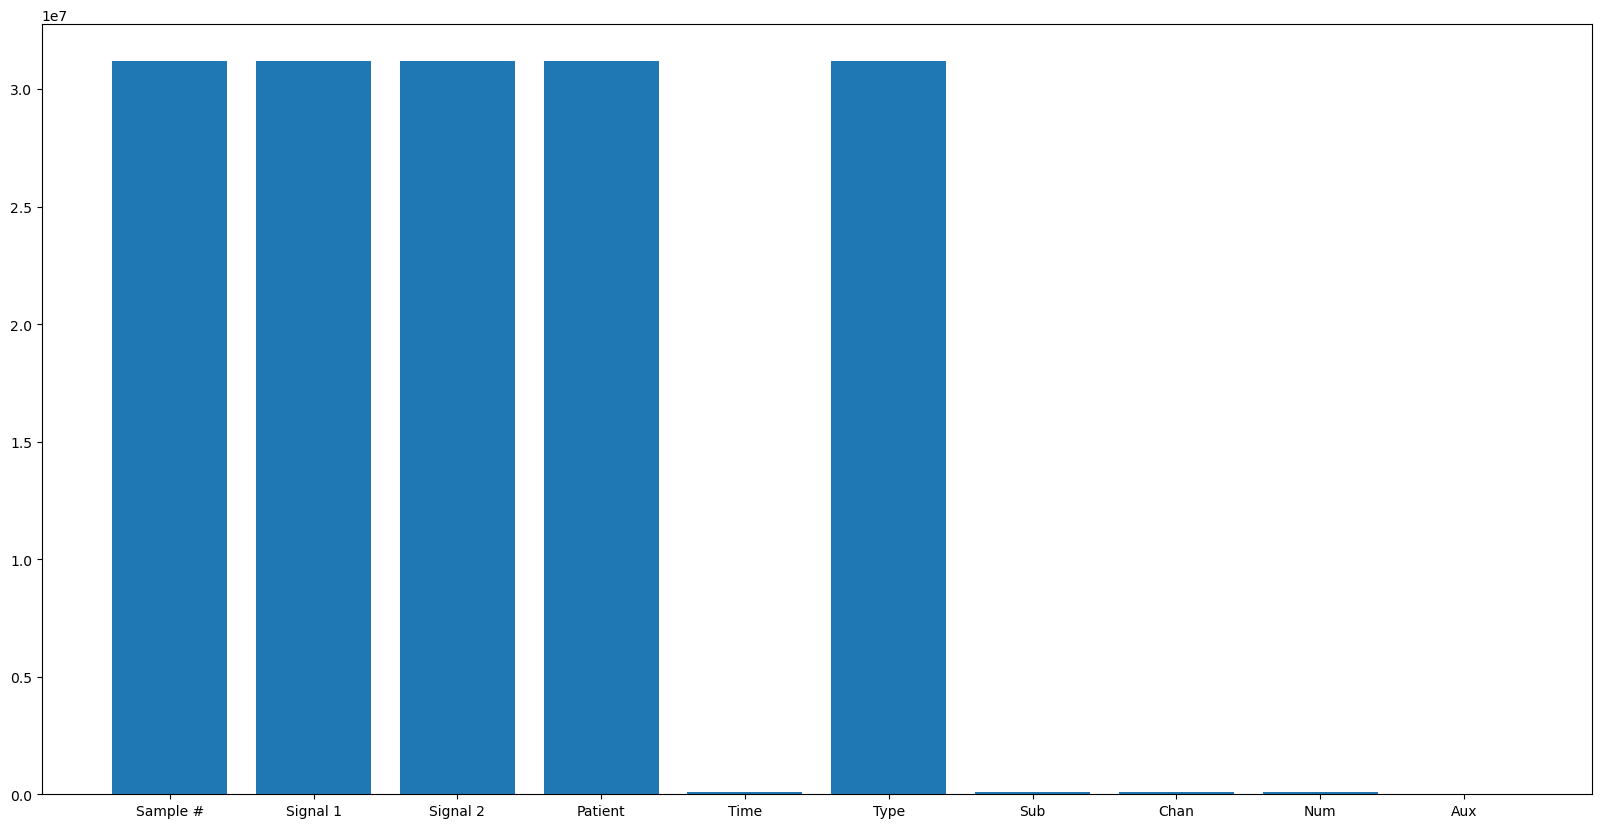

In [26]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [27]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
Signal 1      int64
Signal 2      int64
Patient      object
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [28]:
df.describe()

,Sample #,Signal 1,Signal 2,Sub,Chan,Num
count,3.119753e+07,3.119753e+07,3.119753e+07,112646.000000,112646.0,112646.0
mean,3.250252e+05,9.562826e+02,1.001037e+03,0.062603,0.0,0.0
std,1.876240e+05,9.447422e+01,8.981329e+01,0.406945,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.0,0.0
25%,1.625380e+05,9.070000e+02,9.510000e+02,0.000000,0.0,0.0
50%,3.250250e+05,9.650000e+02,1.019000e+03,0.000000,0.0,0.0
75%,4.875120e+05,9.950000e+02,1.047000e+03,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,2.047000e+03,9.000000,0.0,0.0


array([[<AxesSubplot:title={'center':'Sample #'}>,
        <AxesSubplot:title={'center':'Signal 1'}>],
       [<AxesSubplot:title={'center':'Signal 2'}>,
        <AxesSubplot:title={'center':'Sub'}>],
       [<AxesSubplot:title={'center':'Chan'}>,
        <AxesSubplot:title={'center':'Num'}>]], dtype=object)

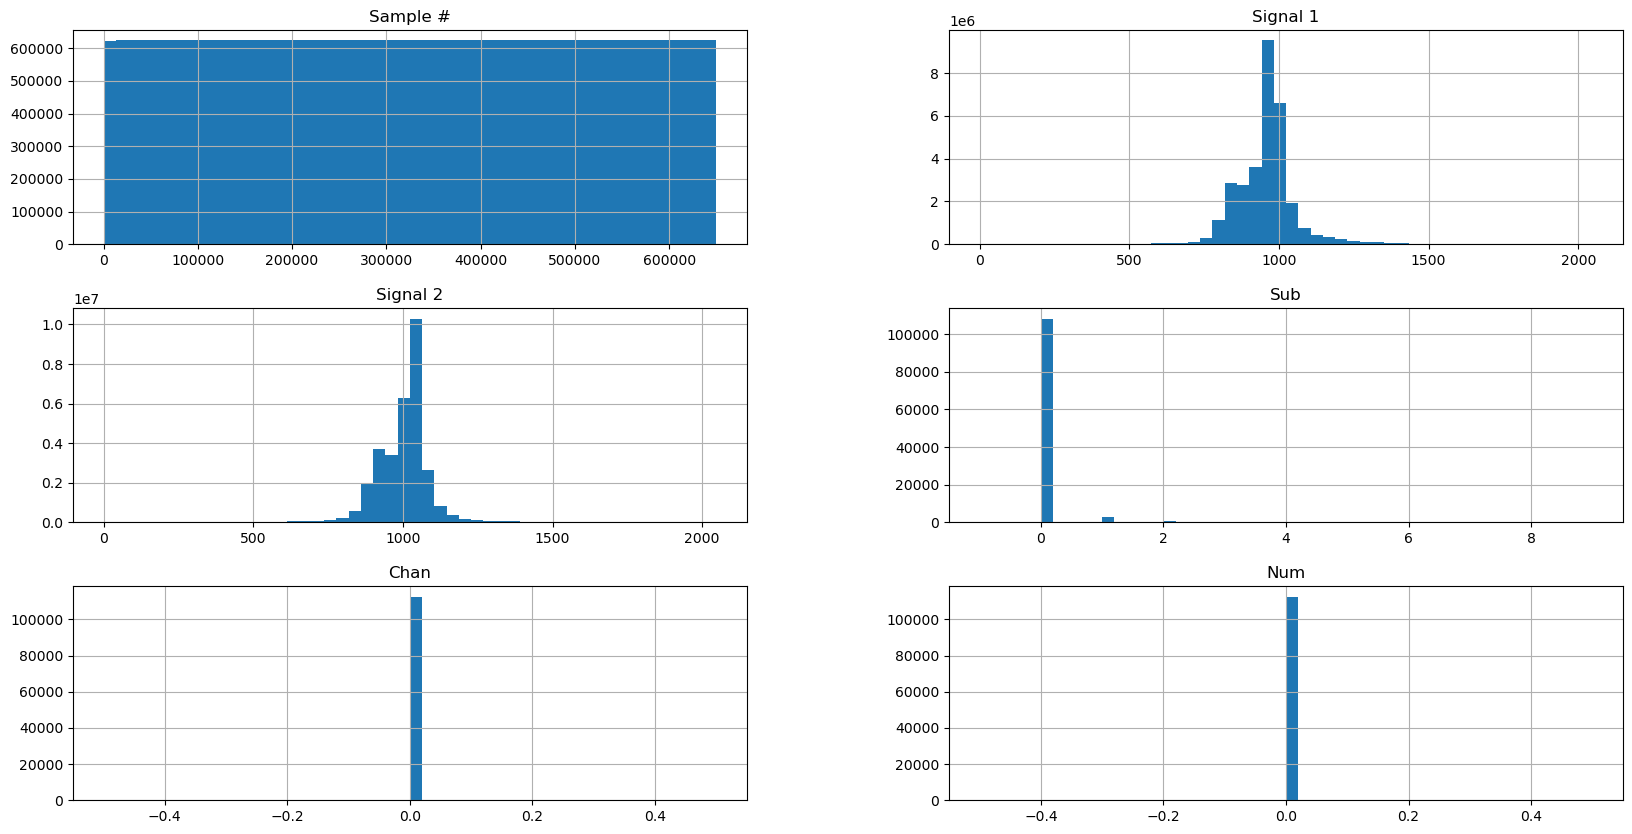

In [29]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

### Filtering signals

In [30]:
# Filtering signals
df['Signal 1'] = df['Signal 1'].rolling(window=5, min_periods=1).mean()
df['Signal 2'] = df['Signal 2'].rolling(window=5, min_periods=1).mean()

# Save df to csv
df.to_csv('dataframes/df.csv', index=False)

## beat_df dataframe

In [31]:
### Statistical metrics

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat (measures were taken at 360Hz)
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

# Delete rows with RR interval < 0 seconds
beat_df = beat_df[beat_df['RR interval'] > 0]

patient_list = []
type_list = []

mean_list1 = []
std_list1 = []
median_list1 = []
mean_absolute_deviation_list1 = []
quantile25_list1 = []
quantile75_list1 = []
iqr_list1 = []
peak_list1 = []
valley_list1 = []
skewness_list1 = []
kurtosis_list1 = []
entropy_list1 = []

mean_list2 = []
std_list2 = []
median_list2 = []
mean_absolute_deviation_list2 = []
quantile25_list2 = []
quantile75_list2 = []
iqr_list2 = []
peak_list2 = []
valley_list2 = []
skewness_list2 = []
kurtosis_list2 = []
entropy_list2 = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for patient_id in df['Patient'].unique():
    print(patient_id)
    for index, row in beat_df.loc[df_copy['Patient'] == patient_id].iterrows():

        sample1 = int(row['sample1'])
        sample2 = int(row['sample2'])

        # Estimate features
        mean = df['Signal 1'][sample1:sample2].mean()
        std = df['Signal 1'][sample1:sample2].std()
        median = df['Signal 1'][sample1:sample2].median()
        mean_absolute_deviation = np.mean(np.abs(df['Signal 1'][sample1:sample2] - mean))
        quantile25 = np.percentile(df['Signal 1'][sample1:sample2], 25)
        quantile75 = np.percentile(df['Signal 1'][sample1:sample2], 75)
        iqr = quantile75 - quantile25
        peak = df['Signal 1'][sample1:sample2].max()
        valley = df['Signal 1'][sample1:sample2].min()
        skewness = stats.skew(df['Signal 1'][sample1:sample2])
        kurtosis = stats.kurtosis(df['Signal 1'][sample1:sample2])
        entropy = stats.entropy(df['Signal 1'][sample1:sample2])

        mean_list1.append(mean)
        std_list1.append(std)
        median_list1.append(median)
        mean_absolute_deviation_list1.append(mean_absolute_deviation)
        quantile25_list1.append(quantile25)
        quantile75_list1.append(quantile75)
        iqr_list1.append(iqr)    
        peak_list1.append(peak)
        valley_list1.append(valley)
        skewness_list1.append(skewness)
        kurtosis_list1.append(kurtosis)
        entropy_list1.append(entropy)      
        
        # Estimate features
        mean = df['Signal 2'][sample1:sample2].mean()
        std = df['Signal 2'][sample1:sample2].std()
        median = df['Signal 2'][sample1:sample2].median()
        mean_absolute_deviation = np.mean(np.abs(df['Signal 2'][sample1:sample2] - mean))
        quantile25 = np.percentile(df['Signal 2'][sample1:sample2], 25)
        quantile75 = np.percentile(df['Signal 2'][sample1:sample2], 75)
        iqr = quantile75 - quantile25
        peak = df['Signal 2'][sample1:sample2].max()
        valley = df['Signal 2'][sample1:sample2].min()
        skewness = stats.skew(df['Signal 2'][sample1:sample2])
        kurtosis = stats.kurtosis(df['Signal 2'][sample1:sample2])
        entropy = stats.entropy(df['Signal 2'][sample1:sample2])

        mean_list2.append(mean)
        std_list2.append(std)
        median_list2.append(median)
        mean_absolute_deviation_list2.append(mean_absolute_deviation)
        quantile25_list2.append(quantile25)
        quantile75_list2.append(quantile75)
        iqr_list2.append(iqr)
        peak_list2.append(peak)
        valley_list2.append(valley)
        skewness_list2.append(skewness)
        kurtosis_list2.append(kurtosis)
        entropy_list2.append(entropy)
        
        # Add patient and type to the lists
        patient_list.append(patient_id)
        type_list.append(df_copy['Type'][index])

# Add a column to beat_df with the features values for each heartbeat
beat_df['Signal 1 mean'] = mean_list1
beat_df['Signal 1 std'] = std_list1
beat_df['Signal 1 median'] = median_list1
beat_df['Signal 1 mean absolute deviation'] = mean_absolute_deviation_list1
beat_df['Signal 1 quantile 25'] = quantile25_list1
beat_df['Signal 1 quantile 75'] = quantile75_list1
beat_df['Signal 1 iqr'] = iqr_list1
beat_df['Signal 1 peak'] = peak_list1
beat_df['Signal 1 valley'] = valley_list1
beat_df['Signal 1 skewness'] = skewness_list1
beat_df['Signal 1 kurtosis'] = kurtosis_list1
beat_df['Signal 1 entropy'] = entropy_list1

beat_df['Signal 2 mean'] = mean_list2
beat_df['Signal 2 std'] = std_list2
beat_df['Signal 2 median'] = median_list2
beat_df['Signal 2 mean absolute deviation'] = mean_absolute_deviation_list2
beat_df['Signal 2 quantile 25'] = quantile25_list2
beat_df['Signal 2 quantile 75'] = quantile75_list2
beat_df['Signal 2 iqr'] = iqr_list2
beat_df['Signal 2 peak'] = peak_list2
beat_df['Signal 2 valley'] = valley_list2
beat_df['Signal 2 skewness'] = skewness_list2
beat_df['Signal 2 kurtosis'] = kurtosis_list2
beat_df['Signal 2 entropy'] = entropy_list2

beat_df['Patient'] = patient_list
beat_df['Type'] = type_list



100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


In [32]:
### Signal metrics

shannon_list1 = []
dominant_frequency_list1 = []
dominant_magnitude_list1 = []

shannon_list2 = []
dominant_frequency_list2 = []
dominant_magnitude_list2 = []

# For each heartbeat in beat_df, compute the PSD and store it
for index, row in beat_df.iterrows():

    # For every 10k samples, print the index
    if index % 10000 == 0:
        print(index)

    sample1 = int(row['sample1'])
    sample2 = int(row['sample2'])

    psd1 = np.abs(np.fft.fft(df['Signal 1'][sample1:sample2]))
    freq1 = np.fft.fftfreq(len(psd1))
    psd2 = np.abs(np.fft.fft(df['Signal 2'][sample1:sample2]))
    freq2 = np.fft.fftfreq(len(psd2))

    # Calculate psd features
    shannon = stats.entropy(psd1)
    peaks, _ = find_peaks(psd1, height=0)

    dominant_frequency = peaks[0] if len(peaks) > 0 else 0
    dominant_magnitude = psd1[peaks[0]] if len(peaks) > 0 else 0

    shannon_list1.append(shannon)
    dominant_frequency_list1.append(dominant_frequency)
    dominant_magnitude_list1.append(dominant_magnitude)

    # Calculate psd features
    shannon = stats.entropy(psd2)
    peaks, _ = find_peaks(psd2, height=0)
    
    dominant_frequency = peaks[0] if len(peaks) > 0 else 0
    dominant_magnitude = psd1[peaks[0]] if len(peaks) > 0 else 0

    shannon_list2.append(shannon)
    dominant_frequency_list2.append(dominant_frequency)
    dominant_magnitude_list2.append(dominant_magnitude)


beat_df['Signal 1 psd entropy'] = shannon_list1
beat_df['Signal 1 psd dominant frequency'] = dominant_frequency_list1
beat_df['Signal 1 psd dominant magnitude'] = dominant_magnitude_list1

beat_df['Signal 2 psd entropy'] = shannon_list2
beat_df['Signal 2 psd dominant frequency'] = dominant_frequency_list2
beat_df['Signal 2 psd dominant magnitude'] = dominant_magnitude_list2

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [33]:
beat_df.head()

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 mean absolute deviation,Signal 1 quantile 25,Signal 1 quantile 75,...,Signal 2 kurtosis,Signal 2 entropy,Patient,Type,Signal 1 psd entropy,Signal 1 psd dominant frequency,Signal 1 psd dominant magnitude,Signal 2 psd entropy,Signal 2 psd dominant frequency,Signal 2 psd dominant magnitude
0,18,77,0,0.163889,983.555932,56.724769,965.6,38.260500,957.50,970.4,...,3.071319,4.076964,100,+,0.869688,2,1334.214324,0.637757,2,1334.214324
1,77,370,1,0.813889,967.148123,33.195346,960.4,14.567326,956.00,968.8,...,18.125418,5.679985,100,N,1.314951,2,1665.941921,0.993889,2,1665.941921
2,370,662,2,0.811111,957.196575,31.293992,955.0,14.432459,944.40,961.4,...,19.436424,5.676445,100,N,1.353112,5,1920.681614,1.075190,4,1641.721612
3,662,946,3,0.788889,954.840141,30.401054,950.8,14.402445,942.35,959.8,...,18.495207,5.648675,100,N,1.305276,2,1196.663758,1.055570,5,1872.856843
4,946,1231,4,0.791667,958.884211,27.396991,954.8,12.975882,947.40,963.8,...,18.997870,5.652339,100,N,1.237608,2,1198.306388,0.895201,2,1198.306388


### Classes grouping

In [34]:
# Group beats with 'Type' value of N, L, R, e and j into the N category
beat_df['Type'].replace(to_replace=['N', 'L', 'R', 'e', 'j'], value='N', inplace=True)

# Group beats with 'Type' value of A, a, J, S into the S category
beat_df['Type'].replace(to_replace=['A', 'a', 'J', 'S'], value='S', inplace=True)

# Group beats with 'Type' value of V, E into the V category
beat_df['Type'].replace(to_replace=['V', 'E'], value='V', inplace=True)

# Group beats with 'Type' value not above (except F) into the Q category
beat_df['Type'].replace(to_replace=['/', 'f', 'Q'], value='Q', inplace=True)

# Eliminate entries with ~, +, x, [, ], !, " and | in 'Type' column
beat_df = beat_df[beat_df['Type'] != '~']
beat_df = beat_df[beat_df['Type'] != '+']
beat_df = beat_df[beat_df['Type'] != 'x']
beat_df = beat_df[beat_df['Type'] != '[']
beat_df = beat_df[beat_df['Type'] != ']']
beat_df = beat_df[beat_df['Type'] != '!']
beat_df = beat_df[beat_df['Type'] != '"']
beat_df = beat_df[beat_df['Type'] != '|']

# Save beat_df to csv
beat_df.to_csv('dataframes/beat_df.csv', index=False)

### Classes count

In [35]:
# Count how many times each Type value appears in the dataset
print(beat_df['Type'].value_counts())

N    90589
Q     8039
V     7236
S     2779
F      803
Name: Type, dtype: int64


### Undersampling beat_df

S    803
V    803
Q    803
F    803
N    803
Name: Type, dtype: int64


,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 mean absolute deviation,Signal 1 quantile 25,Signal 1 quantile 75,...,Signal 2 kurtosis,Signal 2 entropy,Patient,Type,Signal 1 psd entropy,Signal 1 psd dominant frequency,Signal 1 psd dominant magnitude,Signal 2 psd entropy,Signal 2 psd dominant frequency,Signal 2 psd dominant magnitude
105229,111311,111577,105229,0.738889,959.939098,34.114379,953.4,15.524693,950.0,958.40,...,15.159958,5.583141,232,S,1.373021,5,2175.590835,1.173467,5,2175.590835
94025,277585,277876,94025,0.808333,962.164261,36.312891,957.6,17.963444,942.2,967.60,...,20.586250,5.672887,222,S,1.542632,4,2047.959649,1.223766,5,1728.672916
105077,57768,58027,105077,0.719444,955.361390,37.709227,948.8,18.208637,939.0,958.10,...,15.115351,5.556580,232,S,1.276467,4,2530.584348,0.913895,4,2530.584348
71197,417058,417389,71197,0.919444,970.374018,36.623439,966.2,18.636613,950.4,978.30,...,20.918855,5.801713,210,S,1.505857,3,2534.466798,1.231124,2,1391.840469
66592,42451,42709,66592,0.716667,955.105426,39.013701,949.3,18.234746,937.0,956.55,...,15.229295,5.552582,209,S,1.320914,5,2305.987266,1.052747,2,1587.142857


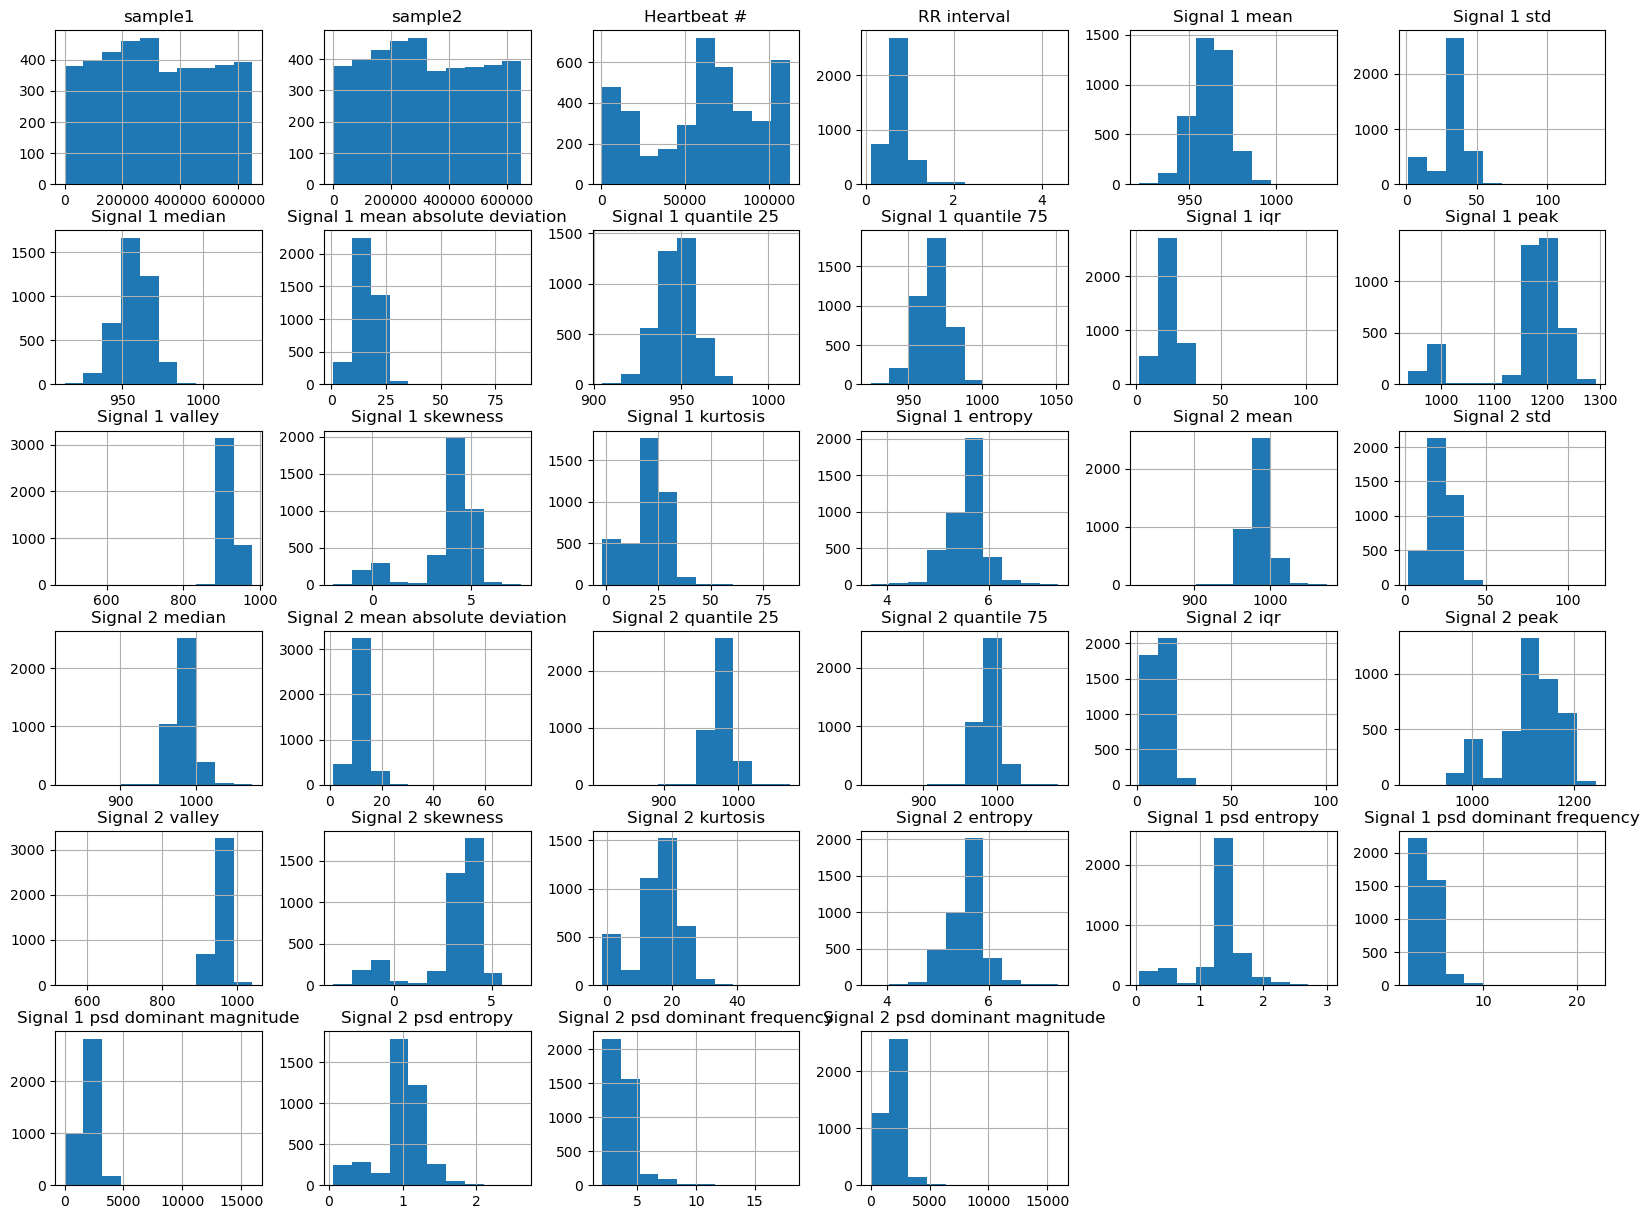

In [36]:
# Identify the majority class by finding the class with the most samples
majority_class = beat_df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = beat_df[beat_df['Type'] == majority_class]
minority_class_data = beat_df[beat_df['Type'] != majority_class]

# Determine the number of samples to keep for each minority class
undersampled_minority_class_size = minority_class_data['Type'].value_counts().min()

# Undersample each minority class
undersampled_minority_data = {}
for minority_class in minority_class_data['Type'].unique():
    undersampled_minority_data[minority_class] = minority_class_data[minority_class_data['Type'] == minority_class].sample(n=undersampled_minority_class_size, random_state=42)

# Undersample the majority class
undersampled_majority_data = majority_class_data.sample(n=undersampled_minority_class_size, random_state=42)

# Combine the undersampled minority and majority classes
processed_df = pd.concat([undersampled_minority_data[minority_class] for minority_class in undersampled_minority_data], axis=0)
processed_df = pd.concat([processed_df, undersampled_majority_data])

# Check the counts for each class
print(processed_df['Type'].value_counts())

processed_df.hist(figsize=(20, 15))

# Delete entries with RR interval > 5 and < 0
processed_df = processed_df[(processed_df['RR interval'] <= 5) & (processed_df['RR interval'] >= 0)]

processed_df.head()

### Scaling beat_df

In [37]:
# Scaling signals
scaler = MinMaxScaler()
Signal1mean = processed_df['Signal 1 mean'].to_numpy()
Signal1std = processed_df['Signal 1 std'].to_numpy()
Signal1median = processed_df['Signal 1 median'].to_numpy()
Signal1meanabsolutedev = processed_df['Signal 1 mean absolute deviation'].to_numpy()
Signal1quantile25 = processed_df['Signal 1 quantile 25'].to_numpy()
Signal1quantile75 = processed_df['Signal 1 quantile 75'].to_numpy()
Signal1iqr = processed_df['Signal 1 iqr'].to_numpy()
Signal1peak = processed_df['Signal 1 peak'].to_numpy()
Signal1valley = processed_df['Signal 1 valley'].to_numpy()
Signal1skewness = processed_df['Signal 1 skewness'].to_numpy()
Signal1kurtosis = processed_df['Signal 1 kurtosis'].to_numpy()
Signal1entropy = processed_df['Signal 1 entropy'].to_numpy()
Signal1psdentropy = processed_df['Signal 1 psd entropy'].to_numpy()
Signal1psddominantfrequency = processed_df['Signal 1 psd dominant frequency'].to_numpy()
Signal1psddominantmagnitude = processed_df['Signal 1 psd dominant magnitude'].to_numpy()

Signal2mean = processed_df['Signal 2 mean'].to_numpy()
Signal2std = processed_df['Signal 2 std'].to_numpy()
Signal2median = processed_df['Signal 2 median'].to_numpy()
Signal2meanabsolutedev = processed_df['Signal 2 mean absolute deviation'].to_numpy()
Signal2quantile25 = processed_df['Signal 2 quantile 25'].to_numpy()
Signal2quantile75 = processed_df['Signal 2 quantile 75'].to_numpy()
Signal2iqr = processed_df['Signal 2 iqr'].to_numpy()
Signal2peak = processed_df['Signal 2 peak'].to_numpy()
Signal2valley = processed_df['Signal 2 valley'].to_numpy()
Signal2skewness = processed_df['Signal 2 skewness'].to_numpy()
Signal2kurtosis = processed_df['Signal 2 kurtosis'].to_numpy()
Signal2entropy = processed_df['Signal 2 entropy'].to_numpy()
Signal2psdentropy = processed_df['Signal 2 psd entropy'].to_numpy()
Signal2psddominantfrequency = processed_df['Signal 2 psd dominant frequency'].to_numpy()
Signal2psddominantmagnitude = processed_df['Signal 2 psd dominant magnitude'].to_numpy()

RR_interval = processed_df['RR interval'].to_numpy()

processed_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
processed_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
processed_df['Signal 1 median'] = scaler.fit_transform(Signal1median.reshape(-1, 1))
processed_df['Signal 1 mean absolute deviation'] = scaler.fit_transform(Signal1meanabsolutedev.reshape(-1, 1))
processed_df['Signal 1 quantile 25'] = scaler.fit_transform(Signal1quantile25.reshape(-1, 1))
processed_df['Signal 1 quantile 75'] = scaler.fit_transform(Signal1quantile75.reshape(-1, 1))
processed_df['Signal 1 iqr'] = scaler.fit_transform(Signal1iqr.reshape(-1, 1))
processed_df['Signal 1 peak'] = scaler.fit_transform(Signal1peak.reshape(-1, 1))
processed_df['Signal 1 valley'] = scaler.fit_transform(Signal1valley.reshape(-1, 1))
processed_df['Signal 1 skewness'] = scaler.fit_transform(Signal1skewness.reshape(-1, 1))
processed_df['Signal 1 kurtosis'] = scaler.fit_transform(Signal1kurtosis.reshape(-1, 1))
processed_df['Signal 1 entropy'] = scaler.fit_transform(Signal1entropy.reshape(-1, 1))
processed_df['Signal 1 psd entropy'] = scaler.fit_transform(Signal1psdentropy.reshape(-1, 1))
processed_df['Signal 1 psd dominant frequency'] = scaler.fit_transform(Signal1psddominantfrequency.reshape(-1, 1))
processed_df['Signal 1 psd dominant magnitude'] = scaler.fit_transform(Signal1psddominantmagnitude.reshape(-1, 1))

processed_df['Signal 2 mean'] = scaler.fit_transform(Signal2mean.reshape(-1, 1))
processed_df['Signal 2 std'] = scaler.fit_transform(Signal2std.reshape(-1, 1))
processed_df['Signal 2 median'] = scaler.fit_transform(Signal2median.reshape(-1, 1))
processed_df['Signal 2 mean absolute deviation'] = scaler.fit_transform(Signal2meanabsolutedev.reshape(-1, 1))
processed_df['Signal 2 quantile 25'] = scaler.fit_transform(Signal2quantile25.reshape(-1, 1))
processed_df['Signal 2 quantile 75'] = scaler.fit_transform(Signal2quantile75.reshape(-1, 1))
processed_df['Signal 2 iqr'] = scaler.fit_transform(Signal2iqr.reshape(-1, 1))
processed_df['Signal 2 peak'] = scaler.fit_transform(Signal2peak.reshape(-1, 1))
processed_df['Signal 2 valley'] = scaler.fit_transform(Signal2valley.reshape(-1, 1))
processed_df['Signal 2 skewness'] = scaler.fit_transform(Signal2skewness.reshape(-1, 1))
processed_df['Signal 2 kurtosis'] = scaler.fit_transform(Signal2kurtosis.reshape(-1, 1))
processed_df['Signal 2 entropy'] = scaler.fit_transform(Signal2entropy.reshape(-1, 1))
processed_df['Signal 2 psd entropy'] = scaler.fit_transform(Signal2psdentropy.reshape(-1, 1))
processed_df['Signal 2 psd dominant frequency'] = scaler.fit_transform(Signal2psddominantfrequency.reshape(-1, 1))
processed_df['Signal 2 psd dominant magnitude'] = scaler.fit_transform(Signal2psddominantmagnitude.reshape(-1, 1))

processed_df['RR interval'] = scaler.fit_transform(RR_interval.reshape(-1, 1))

processed_df.head()

# Save processed_df to csv
processed_df.to_csv('dataframes/processed_df.csv', index=False)

processed_df.head()

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 mean absolute deviation,Signal 1 quantile 25,Signal 1 quantile 75,...,Signal 2 kurtosis,Signal 2 entropy,Patient,Type,Signal 1 psd entropy,Signal 1 psd dominant frequency,Signal 1 psd dominant magnitude,Signal 2 psd entropy,Signal 2 psd dominant frequency,Signal 2 psd dominant magnitude
105229,111311,111577,105229,0.147135,0.357073,0.246985,0.336752,0.169492,0.420857,0.265932,...,0.287815,0.515667,232,S,0.447551,0.15,0.135962,0.436732,0.1875,0.136337
94025,277585,277876,94025,0.163411,0.377775,0.263514,0.372650,0.197920,0.348231,0.338316,...,0.381630,0.540098,222,S,0.505262,0.10,0.127956,0.456528,0.1875,0.108317
105077,57768,58027,105077,0.142578,0.314485,0.274011,0.297436,0.200779,0.318436,0.263572,...,0.287043,0.508436,232,S,0.414699,0.10,0.158229,0.334574,0.1250,0.158594
71197,417058,417389,71197,0.189453,0.454154,0.265848,0.446154,0.205768,0.424581,0.422502,...,0.387381,0.575168,210,S,0.492749,0.05,0.158472,0.459424,0.0000,0.087198
66592,42451,42709,66592,0.141927,0.312104,0.283819,0.301709,0.201083,0.299814,0.251377,...,0.289013,0.507348,209,S,0.429822,0.15,0.144141,0.389221,0.0000,0.099443


C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_16092\179487152.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = processed_df.drop(['sample1', 'sample2', 'Heartbeat #', 'Patient'], axis=1).corr()


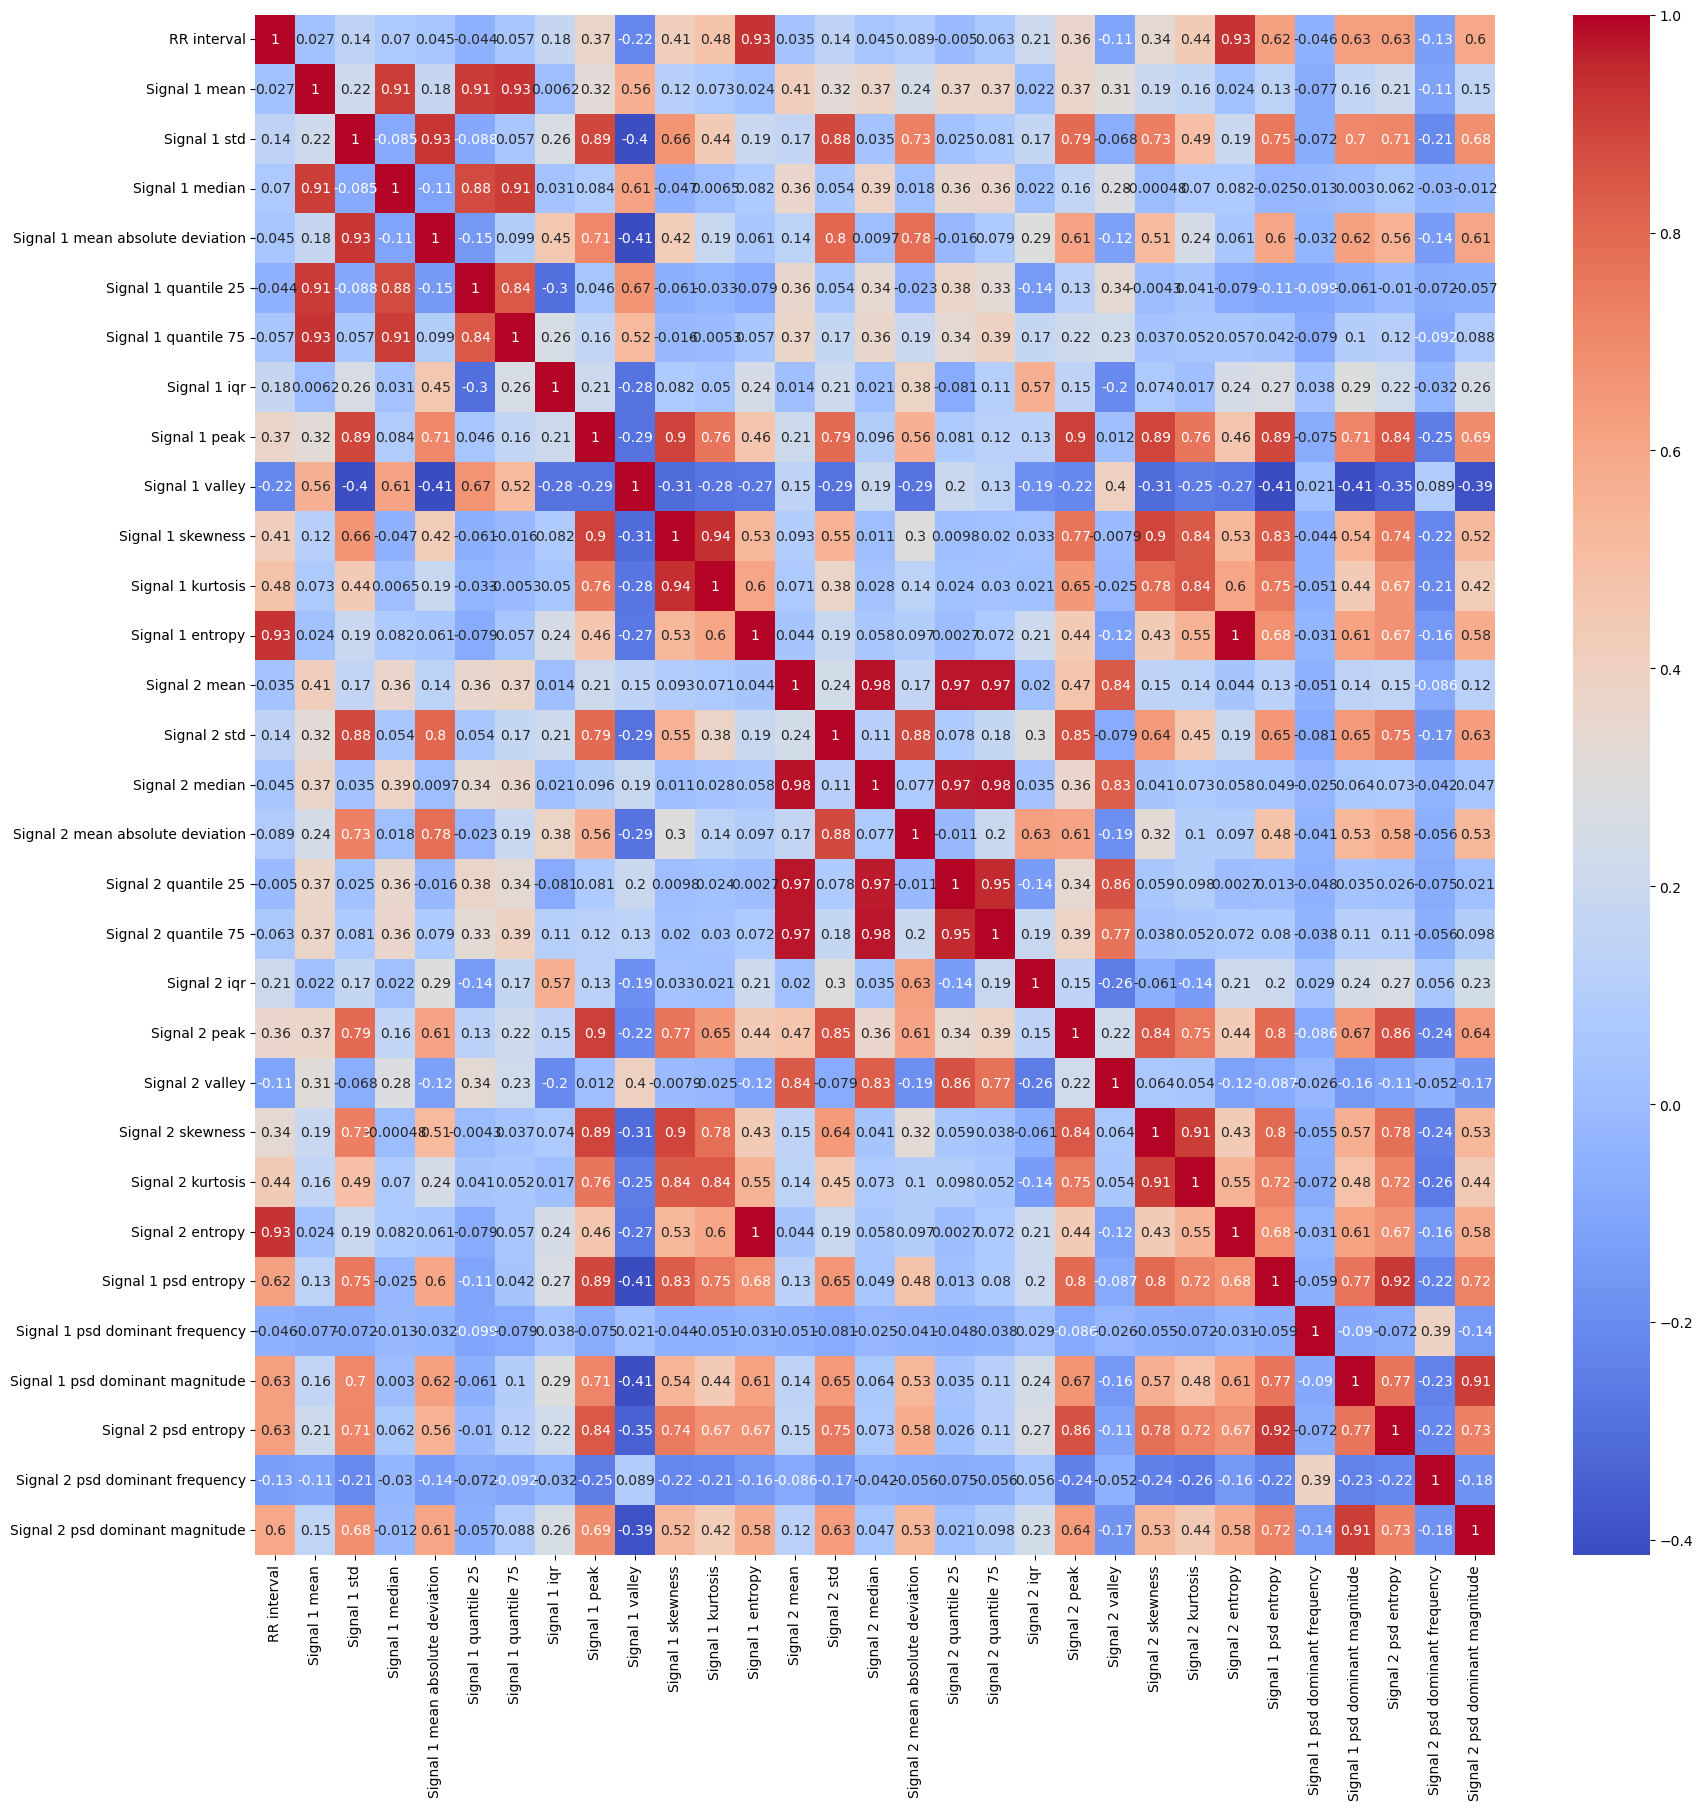

In [38]:
# Plot processed_df features correlation (exclude sample1, sample2, heartbeat # and Patient)
corr = processed_df.drop(['sample1', 'sample2', 'Heartbeat #', 'Patient'], axis=1).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## train_df (balanced) and test_df (unbalanced)

In [39]:
# Split the original DataFrame into two new DataFrames
split_ratio = 0.8
num_samples = len(beat_df)

# Calculate the number of samples for the first split
split_index = int(num_samples * split_ratio)

# Shuffle the DataFrame
shuffled_df = beat_df.sample(frac=1, random_state=100)

# Split the DataFrame
train_df = shuffled_df.iloc[:split_index]
test_df = shuffled_df.iloc[split_index:]

print(num_samples)
print(len(train_df))
print(len(test_df))

109446
87556
21890


### Undersampling train_df

In [40]:
# Identify the majority class by finding the class with the most samples
majority_class = train_df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = train_df[train_df['Type'] == majority_class]
minority_class_data = train_df[train_df['Type'] != majority_class]

# Determine the number of samples you want to keep for each minority class
# You can set this number based on the number of samples in the smallest minority class
undersampled_minority_class_size = minority_class_data['Type'].value_counts().min()

# Undersample each minority class
undersampled_minority_data = {}
for minority_class in minority_class_data['Type'].unique():
    undersampled_minority_data[minority_class] = minority_class_data[minority_class_data['Type'] == minority_class].sample(n=undersampled_minority_class_size, random_state=42)

# Undersample the majority class
undersampled_majority_data = majority_class_data.sample(n=undersampled_minority_class_size, random_state=42)

# Combine the undersampled minority and majority classes
train_df = pd.concat([undersampled_minority_data[minority_class] for minority_class in undersampled_minority_data], axis=0)
train_df = train_df.append(undersampled_majority_data, ignore_index=True)

# Check the counts for each class
print(train_df['Type'].value_counts())

# Delete entries with RR interval > 5 and < 0
train_df = train_df[(train_df['RR interval'] <= 5) & (train_df['RR interval'] >= 0)]

train_df.head()

Q    638
V    638
S    638
F    638
N    638
Name: Type, dtype: int64


C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_16092\2400928957.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(undersampled_majority_data, ignore_index=True)


,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 mean absolute deviation,Signal 1 quantile 25,Signal 1 quantile 75,...,Signal 2 kurtosis,Signal 2 entropy,Patient,Type,Signal 1 psd entropy,Signal 1 psd dominant frequency,Signal 1 psd dominant magnitude,Signal 2 psd entropy,Signal 2 psd dominant frequency,Signal 2 psd dominant magnitude
0,246958,247232,9358,0.761111,977.307299,36.386787,973.8,18.536955,958.4,983.1,...,16.826381,5.612777,104,Q,1.387203,4,2314.368881,1.052641,2,1793.866951
1,248083,248408,9362,0.902778,962.587692,33.601647,957.8,17.676383,944.4,970.8,...,17.424330,5.783466,104,Q,1.458584,6,2198.136517,1.226417,6,2198.136517
2,188969,189246,9145,0.769444,976.890975,32.333566,973.2,14.602255,962.6,979.8,...,20.609433,5.623784,104,Q,1.308893,2,1560.986692,0.977087,2,1560.986692
3,640759,641064,17640,0.847222,963.051803,36.661457,955.0,16.283597,950.4,964.4,...,23.564233,5.720022,107,Q,1.429487,2,1876.790312,1.104932,2,1876.790312
4,616928,617232,86068,0.844444,984.163158,41.412933,978.0,18.040270,967.8,982.8,...,21.978120,5.716548,217,Q,1.547458,5,2974.207877,1.269064,5,2974.207877


### Scaling train_df

In [41]:
# Scaling signals
scaler = MinMaxScaler()
Signal1mean = train_df['Signal 1 mean'].to_numpy()
Signal1std = train_df['Signal 1 std'].to_numpy()
Signal1median = train_df['Signal 1 median'].to_numpy()
Signal1meanabsolutedev = train_df['Signal 1 mean absolute deviation'].to_numpy()
Signal1quantile25 = train_df['Signal 1 quantile 25'].to_numpy()
Signal1quantile75 = train_df['Signal 1 quantile 75'].to_numpy()
Signal1iqr = train_df['Signal 1 iqr'].to_numpy()
Signal1peak = train_df['Signal 1 peak'].to_numpy()
Signal1valley = train_df['Signal 1 valley'].to_numpy()
Signal1skewness = train_df['Signal 1 skewness'].to_numpy()
Signal1kurtosis = train_df['Signal 1 kurtosis'].to_numpy()
Signal1entropy = train_df['Signal 1 entropy'].to_numpy()
Signal1psdentropy = train_df['Signal 1 psd entropy'].to_numpy()
Signal1psddominantfrequency = train_df['Signal 1 psd dominant frequency'].to_numpy()
Signal1psddominantmagnitude = train_df['Signal 1 psd dominant magnitude'].to_numpy()

Signal2mean = train_df['Signal 2 mean'].to_numpy()
Signal2std = train_df['Signal 2 std'].to_numpy()
Signal2median = train_df['Signal 2 median'].to_numpy()
Signal2meanabsolutedev = train_df['Signal 2 mean absolute deviation'].to_numpy()
Signal2quantile25 = train_df['Signal 2 quantile 25'].to_numpy()
Signal2quantile75 = train_df['Signal 2 quantile 75'].to_numpy()
Signal2iqr = train_df['Signal 2 iqr'].to_numpy()
Signal2peak = train_df['Signal 2 peak'].to_numpy()
Signal2valley = train_df['Signal 2 valley'].to_numpy()
Signal2skewness = train_df['Signal 2 skewness'].to_numpy()
Signal2kurtosis = train_df['Signal 2 kurtosis'].to_numpy()
Signal2entropy = train_df['Signal 2 entropy'].to_numpy()
Signal2psdentropy = train_df['Signal 2 psd entropy'].to_numpy()
Signal2psddominantfrequency = train_df['Signal 2 psd dominant frequency'].to_numpy()
Signal2psddominantmagnitude = train_df['Signal 2 psd dominant magnitude'].to_numpy()

RR_interval = train_df['RR interval'].to_numpy()

train_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
train_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
train_df['Signal 1 median'] = scaler.fit_transform(Signal1median.reshape(-1, 1))
train_df['Signal 1 mean absolute deviation'] = scaler.fit_transform(Signal1meanabsolutedev.reshape(-1, 1))
train_df['Signal 1 quantile 25'] = scaler.fit_transform(Signal1quantile25.reshape(-1, 1))
train_df['Signal 1 quantile 75'] = scaler.fit_transform(Signal1quantile75.reshape(-1, 1))
train_df['Signal 1 iqr'] = scaler.fit_transform(Signal1iqr.reshape(-1, 1))
train_df['Signal 1 peak'] = scaler.fit_transform(Signal1peak.reshape(-1, 1))
train_df['Signal 1 valley'] = scaler.fit_transform(Signal1valley.reshape(-1, 1))
train_df['Signal 1 skewness'] = scaler.fit_transform(Signal1skewness.reshape(-1, 1))
train_df['Signal 1 kurtosis'] = scaler.fit_transform(Signal1kurtosis.reshape(-1, 1))
train_df['Signal 1 entropy'] = scaler.fit_transform(Signal1entropy.reshape(-1, 1))
train_df['Signal 1 psd entropy'] = scaler.fit_transform(Signal1psdentropy.reshape(-1, 1))
train_df['Signal 1 psd dominant frequency'] = scaler.fit_transform(Signal1psddominantfrequency.reshape(-1, 1))
train_df['Signal 1 psd dominant magnitude'] = scaler.fit_transform(Signal1psddominantmagnitude.reshape(-1, 1))

train_df['Signal 2 mean'] = scaler.fit_transform(Signal2mean.reshape(-1, 1))
train_df['Signal 2 std'] = scaler.fit_transform(Signal2std.reshape(-1, 1))
train_df['Signal 2 median'] = scaler.fit_transform(Signal2median.reshape(-1, 1))
train_df['Signal 2 mean absolute deviation'] = scaler.fit_transform(Signal2meanabsolutedev.reshape(-1, 1))
train_df['Signal 2 quantile 25'] = scaler.fit_transform(Signal2quantile25.reshape(-1, 1))
train_df['Signal 2 quantile 75'] = scaler.fit_transform(Signal2quantile75.reshape(-1, 1))
train_df['Signal 2 iqr'] = scaler.fit_transform(Signal2iqr.reshape(-1, 1))
train_df['Signal 2 peak'] = scaler.fit_transform(Signal2peak.reshape(-1, 1))
train_df['Signal 2 valley'] = scaler.fit_transform(Signal2valley.reshape(-1, 1))
train_df['Signal 2 skewness'] = scaler.fit_transform(Signal2skewness.reshape(-1, 1))
train_df['Signal 2 kurtosis'] = scaler.fit_transform(Signal2kurtosis.reshape(-1, 1))
train_df['Signal 2 entropy'] = scaler.fit_transform(Signal2entropy.reshape(-1, 1))
train_df['Signal 2 psd entropy'] = scaler.fit_transform(Signal2psdentropy.reshape(-1, 1))
train_df['Signal 2 psd dominant frequency'] = scaler.fit_transform(Signal2psddominantfrequency.reshape(-1, 1))
train_df['Signal 2 psd dominant magnitude'] = scaler.fit_transform(Signal2psddominantmagnitude.reshape(-1, 1))

train_df['RR interval'] = scaler.fit_transform(RR_interval.reshape(-1, 1))

train_df.head()

# Save train_df to csv
train_df.to_csv('dataframes/train_df.csv', index=False)

### Scaling test_df

In [42]:
# Scaling signals
scaler = MinMaxScaler()
Signal1mean = test_df['Signal 1 mean'].to_numpy()
Signal1std = test_df['Signal 1 std'].to_numpy()
Signal1median = test_df['Signal 1 median'].to_numpy()
Signal1meanabsolutedev = test_df['Signal 1 mean absolute deviation'].to_numpy()
Signal1quantile25 = test_df['Signal 1 quantile 25'].to_numpy()
Signal1quantile75 = test_df['Signal 1 quantile 75'].to_numpy()
Signal1iqr = test_df['Signal 1 iqr'].to_numpy()
Signal1peak = test_df['Signal 1 peak'].to_numpy()
Signal1valley = test_df['Signal 1 valley'].to_numpy()
Signal1skewness = test_df['Signal 1 skewness'].to_numpy()
Signal1kurtosis = test_df['Signal 1 kurtosis'].to_numpy()
Signal1entropy = test_df['Signal 1 entropy'].to_numpy()
Signal1psdentropy = test_df['Signal 1 psd entropy'].to_numpy()
Signal1psddominantfrequency = test_df['Signal 1 psd dominant frequency'].to_numpy()
Signal1psddominantmagnitude = test_df['Signal 1 psd dominant magnitude'].to_numpy()

Signal2mean = test_df['Signal 2 mean'].to_numpy()
Signal2std = test_df['Signal 2 std'].to_numpy()
Signal2median = test_df['Signal 2 median'].to_numpy()
Signal2meanabsolutedev = test_df['Signal 2 mean absolute deviation'].to_numpy()
Signal2quantile25 = test_df['Signal 2 quantile 25'].to_numpy()
Signal2quantile75 = test_df['Signal 2 quantile 75'].to_numpy()
Signal2iqr = test_df['Signal 2 iqr'].to_numpy()
Signal2peak = test_df['Signal 2 peak'].to_numpy()
Signal2valley = test_df['Signal 2 valley'].to_numpy()
Signal2skewness = test_df['Signal 2 skewness'].to_numpy()
Signal2kurtosis = test_df['Signal 2 kurtosis'].to_numpy()
Signal2entropy = test_df['Signal 2 entropy'].to_numpy()
Signal2psdentropy = test_df['Signal 2 psd entropy'].to_numpy()
Signal2psddominantfrequency = test_df['Signal 2 psd dominant frequency'].to_numpy()
Signal2psddominantmagnitude = test_df['Signal 2 psd dominant magnitude'].to_numpy()

RR_interval = test_df['RR interval'].to_numpy()

test_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
test_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
test_df['Signal 1 median'] = scaler.fit_transform(Signal1median.reshape(-1, 1))
test_df['Signal 1 mean absolute deviation'] = scaler.fit_transform(Signal1meanabsolutedev.reshape(-1, 1))
test_df['Signal 1 quantile 25'] = scaler.fit_transform(Signal1quantile25.reshape(-1, 1))
test_df['Signal 1 quantile 75'] = scaler.fit_transform(Signal1quantile75.reshape(-1, 1))
test_df['Signal 1 iqr'] = scaler.fit_transform(Signal1iqr.reshape(-1, 1))
test_df['Signal 1 peak'] = scaler.fit_transform(Signal1peak.reshape(-1, 1))
test_df['Signal 1 valley'] = scaler.fit_transform(Signal1valley.reshape(-1, 1))
test_df['Signal 1 skewness'] = scaler.fit_transform(Signal1skewness.reshape(-1, 1))
test_df['Signal 1 kurtosis'] = scaler.fit_transform(Signal1kurtosis.reshape(-1, 1))
test_df['Signal 1 entropy'] = scaler.fit_transform(Signal1entropy.reshape(-1, 1))
test_df['Signal 1 psd entropy'] = scaler.fit_transform(Signal1psdentropy.reshape(-1, 1))
test_df['Signal 1 psd dominant frequency'] = scaler.fit_transform(Signal1psddominantfrequency.reshape(-1, 1))
test_df['Signal 1 psd dominant magnitude'] = scaler.fit_transform(Signal1psddominantmagnitude.reshape(-1, 1))

test_df['Signal 2 mean'] = scaler.fit_transform(Signal2mean.reshape(-1, 1))
test_df['Signal 2 std'] = scaler.fit_transform(Signal2std.reshape(-1, 1))
test_df['Signal 2 median'] = scaler.fit_transform(Signal2median.reshape(-1, 1))
test_df['Signal 2 mean absolute deviation'] = scaler.fit_transform(Signal2meanabsolutedev.reshape(-1, 1))
test_df['Signal 2 quantile 25'] = scaler.fit_transform(Signal2quantile25.reshape(-1, 1))
test_df['Signal 2 quantile 75'] = scaler.fit_transform(Signal2quantile75.reshape(-1, 1))
test_df['Signal 2 iqr'] = scaler.fit_transform(Signal2iqr.reshape(-1, 1))
test_df['Signal 2 peak'] = scaler.fit_transform(Signal2peak.reshape(-1, 1))
test_df['Signal 2 valley'] = scaler.fit_transform(Signal2valley.reshape(-1, 1))
test_df['Signal 2 skewness'] = scaler.fit_transform(Signal2skewness.reshape(-1, 1))
test_df['Signal 2 kurtosis'] = scaler.fit_transform(Signal2kurtosis.reshape(-1, 1))
test_df['Signal 2 entropy'] = scaler.fit_transform(Signal2entropy.reshape(-1, 1))
test_df['Signal 2 psd entropy'] = scaler.fit_transform(Signal2psdentropy.reshape(-1, 1))
test_df['Signal 2 psd dominant frequency'] = scaler.fit_transform(Signal2psddominantfrequency.reshape(-1, 1))
test_df['Signal 2 psd dominant magnitude'] = scaler.fit_transform(Signal2psddominantmagnitude.reshape(-1, 1))

test_df['RR interval'] = scaler.fit_transform(RR_interval.reshape(-1, 1))

# Save test_df to csv
test_df.to_csv('dataframes/test_df.csv', index=False)

test_df.head()

C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_16092\3834786719.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_16092\3834786719.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_16092\3834786719.py:39: SettingWithCopyWarning: 
A value is trying to be se

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 mean absolute deviation,Signal 1 quantile 25,Signal 1 quantile 75,...,Signal 2 kurtosis,Signal 2 entropy,Patient,Type,Signal 1 psd entropy,Signal 1 psd dominant frequency,Signal 1 psd dominant magnitude,Signal 2 psd entropy,Signal 2 psd dominant frequency,Signal 2 psd dominant magnitude
54188,427161,427338,54188,0.075651,0.236952,0.283182,0.210485,0.202161,0.250420,0.123478,...,0.287179,0.440527,202,N,0.390366,0.033333,0.113274,0.316915,0.032258,0.113474
13115,575662,575905,13115,0.108717,0.263850,0.191807,0.299444,0.128043,0.273950,0.193146,...,0.338729,0.513376,105,N,0.595455,0.066667,0.063622,0.267289,0.000000,0.091256
105193,98922,99180,105193,0.116232,0.458200,0.270150,0.455123,0.190304,0.444118,0.290003,...,0.407546,0.527042,232,S,0.418126,0.066667,0.149722,0.402066,0.064516,0.149914
24567,101917,102166,24567,0.111723,0.342256,0.228810,0.375695,0.180384,0.302521,0.258284,...,0.289813,0.518932,112,N,0.455804,0.133333,0.080042,0.339928,0.032258,0.100990
23355,408466,408777,23355,0.142786,0.307145,0.222486,0.332804,0.141793,0.309244,0.203908,...,0.514166,0.570016,111,N,0.437424,0.066667,0.123604,0.354393,0.064516,0.123802


### Feature Selection

In [43]:
# Split the data into features and target
X = train_df.drop(['sample1', 'sample2', 'Heartbeat #', 'Patient', 'Type'], axis=1)
y = train_df['Type']

# Encode y
y = LabelEncoder().fit_transform(y)

# Initialize an RFECV object with a minimum number of features of 29
rfe = RFECV(estimator=XGBClassifier(random_state=100), cv=StratifiedKFold(n_splits=5), scoring='f1_macro', min_features_to_select=0.3)
# Fit the RFECV object to the data
rfe.fit(X, y)
xgboost_score = max(np.mean(rfe.grid_scores_, axis=1))

# Initialize an RFECV object with a minimum number of features of 29
rfe = RFECV(estimator=DecisionTreeClassifier(random_state=100), cv=StratifiedKFold(n_splits=5), scoring='f1_macro', min_features_to_select=0.3)
# Fit the RFECV object to the data
rfe.fit(X, y)
decisiontree_score = max(np.mean(rfe.grid_scores_, axis=1))

# Initialize an RFECV object with a minimum number of features of 29
rfe = RFECV(estimator=RandomForestClassifier(random_state=100), cv=StratifiedKFold(n_splits=5), scoring='f1_macro', min_features_to_select=0.3)
# Fit the RFECV object to the data
rfe.fit(X, y)
randomforest_score = max(np.mean(rfe.grid_scores_, axis=1))

# Get the selected features
selected_features = rfe.get_support(indices=True)
col_names = list(X.columns[selected_features])

c:\Users\AndreLopes\miniconda3\envs\adv_automation\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
c:\Users\AndreLopes\miniconda3\envs\adv_automation\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
c:\Users\AndreLopes\miniconda3\envs\adv_automation\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


In [44]:
print('XGBoost score: ', xgboost_score)
print('Decision Tree score: ', decisiontree_score)
print('Random Forest score: ', randomforest_score)

# Get the selected features
selected_features = rfe.get_support(indices=True)
# Print the names of the selected features
print('Selected features: ', X.columns[selected_features])

# Edit train_df and test_df to only include the selected features
train_df = train_df[col_names + ['Type']]
test_df = test_df[col_names + ['Type']]

XGBoost score:  0.5396566012889851
Decision Tree score:  0.4708504769438238
Random Forest score:  0.5555709325145466
Selected features:  Index(['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 1 iqr',
       'Signal 1 valley', 'Signal 1 skewness', 'Signal 1 kurtosis',
       'Signal 1 entropy', 'Signal 2 mean', 'Signal 2 std', 'Signal 2 iqr',
       'Signal 2 valley', 'Signal 2 skewness', 'Signal 2 kurtosis',
       'Signal 2 entropy', 'Signal 1 psd entropy',
       'Signal 1 psd dominant magnitude', 'Signal 2 psd entropy',
       'Signal 2 psd dominant magnitude'],
      dtype='object')


c:\Users\AndreLopes\miniconda3\envs\adv_automation\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


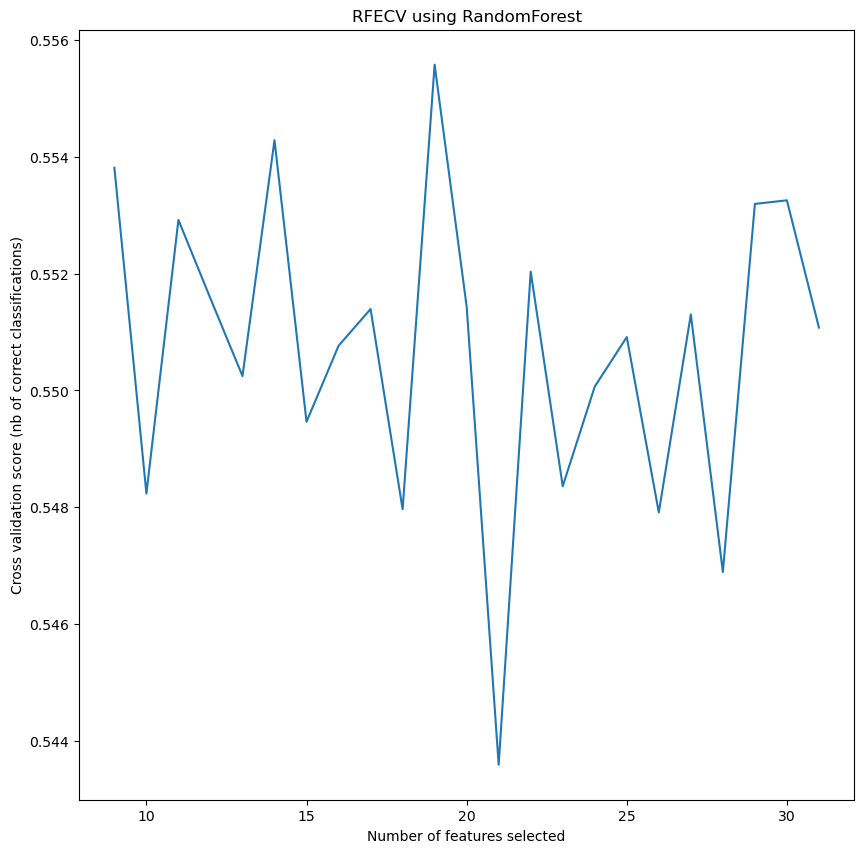

In [45]:
# Plot the RFECV score vs number of features (calculate the mean for each number of features selected)
plt.figure(figsize=(10, 10))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.title('RFECV using RandomForest')
plt.plot(range(9, 32), np.mean(rfe.grid_scores_, axis=1))
plt.show()

In [46]:
# Save train_df to csv
train_df.to_csv('dataframes/train_df.csv', index=False)
# Save test_df to csv
test_df.to_csv('dataframes/test_df.csv', index=False)